In [1]:
import os
import tensorflow as tf
from tensorflow.keras import layers, models
import cv2
from face_tracking import data_collection
import numpy as np
import random
import albumentations as alb
import matplotlib.pyplot as plt
import time
from helpers import display_progressbar

#### Configure GPU for training

In [2]:
# To use GPU, use google colab :(

#gpus = tf.config.list_physical_devices('GPU')
#print(gpus)
#for gpu in gpus:
#    tf.config.experimental.set_memory_growth(gpu, True)

#### Set paths Global Variables and get Face Detector

In [3]:
CELEB_ORIG_PATH = os.path.join('data', 'img_align_celeba')
UNKNOWN_FACES_PATH = os.path.join('data', 'unknown_faces')
KNOWN_FACES_PATH = os.path.join('data', 'known_faces')
KNOWN_FACE_PATH = os.path.join(KNOWN_FACES_PATH, 'stephen') # Change path for different identities

NUM_UNKNOWN_IMAGES = 10000

PERCENT_TRAINING = 80
PERCENT_TESTING = 10
PERCENT_VALIDATION = 10
NUM_AUGMENTATIONS_PER_IMAGE = 50
MODEL_INPUT_IMAGE_DIMENSIONS = (100, 100)
NUM_EPOCHS = 50

Face_Detector = cv2.dnn.readNetFromCaffe("do_not_delete/deploy.prototxt.txt",
                                             "do_not_delete/res10_300x300_ssd_iter_140000.caffemodel")

#### Process, Crop, and move celebrety faces to unknown faces path

In [4]:
def process_unknown_faces():
    t_orig = time.time()
    total_photos = len(os.listdir(CELEB_ORIG_PATH))
    total_processed = 0
    t = time.time()
    exceptions = []
    print("Processing {} photos...".format(total_photos))
    for face in os.listdir(CELEB_ORIG_PATH):
        if str.endswith(face, '.jpg'):
            image = cv2.imread(str(os.path.join(CELEB_ORIG_PATH, face)))
        
            (h, w) = image.shape[:2]

            blob = cv2.dnn.blobFromImage(cv2.resize(image, (300, 300)), 1.0, (300, 300), (104.0, 177.0, 123.0))

            Face_Detector.setInput(blob)
            detections = Face_Detector.forward()

            confidence = -1
            i = 0
            for j in range(0, detections.shape[2]):
                if detections[0, 0, j, 2] > confidence:
                    confidence = detections[0, 0, j, 2]
                    i = j

            if confidence > .9:
                box = detections[0, 0, i, 3:7] * np.array([w, h, w, h])
                (startX, startY, endX, endY) = box.astype("int")
                try:
                    image = cv2.resize(image[max(startY, 0):endY, max(startX, 0):endX], 
                                    MODEL_INPUT_IMAGE_DIMENSIONS, 
                                    interpolation=cv2.INTER_LINEAR)
                    if not cv2.imwrite(str(os.path.join(UNKNOWN_FACES_PATH, face)), image):
                        print("FAILED !!!!!")
                except Exception as e:
                    exceptions.append(e)
            total_processed += 1
            t = display_progressbar(t1=t, t_orig=t_orig, total_photos=total_photos, total_processed=total_processed)
        
    print("\r\nDone!")
    if len(exceptions) > 0:
        print("Some exceptions occurred:")
        for e in exceptions:
            print(e)

In [5]:
if len(os.listdir(UNKNOWN_FACES_PATH)) > 0:
    print("Found files in directory already. To rerun, please empty " + UNKNOWN_FACES_PATH)
else:
    process_unknown_faces()    

Found files in directory already. To rerun, please empty data/unknown_faces


#### Capture, crop, and process images of target face

In [6]:
if len(os.listdir(KNOWN_FACE_PATH)) > 0:
    print("Found files in directory already. To rerun, please empty " + KNOWN_FACE_PATH)
else:
    data_collection(KNOWN_FACE_PATH, 10000)

Found files in directory already. To rerun, please empty data/known_faces/stephen


#### Define data preprosessor functions

In [7]:
def preprocess(file_path):

    # Read in image from file path
    byte_img = tf.io.read_file(file_path)
    # Load in the image
    img = tf.io.decode_jpeg(byte_img)
    
    # Preprocessing steps - resizing the image to be 100x100x3
    img = tf.image.resize(img, MODEL_INPUT_IMAGE_DIMENSIONS)
    # Scale image to be between 0 and 1
    img = img / 255.0
    #Convert to numpy array
    img = np.array(img)

    # Return image
    return img

In [8]:
def get_distribution_array(size, percent_training, percent_validation, percent_testing):
    # Training is 0
    # Validation is 1
    # Testing is 2
    if percent_training <= 0 or percent_validation <= 0 or percent_testing <= 0 or percent_training + percent_validation + percent_testing > 100:
        raise ValueError('percent_training, percent_validation, and percent_testing must add to 100')
    number_of_0s = int((size * percent_training) // 1)
    number_of_1s = int((size * percent_validation) // 1)
    number_of_2s = int((size * percent_testing) // 1)
    arr = [0] * (number_of_0s) + [1] * (number_of_1s) + [2] * number_of_2s
    while len(arr) < size:
        arr.append(0)
    random.shuffle(arr)
    return arr

In [9]:
def shuffle_arrays_in_sync(l1, l2):
    if len(l1) != len(l2):
        raise ValueError("Arrays must be same length")
    arr = []
    l1_final = [0]*len(l1)
    l2_final = [0]*len(l2)
    for i in range(len(l1)):
        arr.append(i)
    for i in range(len(l1)):
        j = random.randint(0, len(arr)-1)
        k = arr.pop(j)
        l1_final[i] = l1[k]
        l2_final[i] = l2[k]
    return l1_final, l2_final

#### Partition Unaugmented Data

In [37]:
known_faces_dir = os.listdir(KNOWN_FACE_PATH)
unknown_faces_dir = os.listdir(UNKNOWN_FACES_PATH)
num_known_faces = len(known_faces_dir)
nun_unknown_faces = len(unknown_faces_dir)

process_known_face = get_distribution_array(num_known_faces, percent_training=PERCENT_TRAINING, percent_testing=PERCENT_TESTING, percent_validation=PERCENT_VALIDATION)
process_unknown_face = get_distribution_array(nun_unknown_faces, percent_training=PERCENT_TRAINING, percent_testing=PERCENT_TESTING, percent_validation=PERCENT_VALIDATION)

(training_images, training_labels), (test_images, test_labels), (val_images, val_labels) = ([], []), ([], []), ([], [])

t_orig = time.time()
total_photos = len(known_faces_dir)
total_processed = 0
t = time.time()
print("Processing {} known faces...".format(total_photos))
for i in range(len(known_faces_dir)):
    if process_known_face[i] == 0:
        training_images.append(preprocess(os.path.join(KNOWN_FACE_PATH, known_faces_dir[i])))
        training_labels.append(1)
    elif process_known_face[i] == 1:
        val_images.append(preprocess(os.path.join(KNOWN_FACE_PATH, known_faces_dir[i])))
        val_labels.append(1)
    else:
        test_images.append(preprocess(os.path.join(KNOWN_FACE_PATH, known_faces_dir[i])))
        test_labels.append(1)
    total_processed += 1
    t = display_progressbar(t1=t, t_orig=t_orig, total_photos=total_photos, total_processed=total_processed)
display_progressbar(t1=10, t_orig=0, total_photos=total_photos, total_processed=total_photos)
print("\r\nDone!")

t_orig = time.time()
total_photos = NUM_UNKNOWN_IMAGES
total_processed = 0
t = time.time()
print("Processing {} unknown faces...".format(total_photos))
for i in range(len(unknown_faces_dir)):
    if i > NUM_UNKNOWN_IMAGES:
        break
    if process_unknown_face[i] == 0:
        training_images.append(preprocess(os.path.join(UNKNOWN_FACES_PATH, unknown_faces_dir[i])))
        training_labels.append(0)
    elif process_unknown_face[i] == 1:
        val_images.append(preprocess(os.path.join(UNKNOWN_FACES_PATH, unknown_faces_dir[i])))
        val_labels.append(0)
    else:
        test_images.append(preprocess(os.path.join(UNKNOWN_FACES_PATH, unknown_faces_dir[i])))
        test_labels.append(0)
    total_processed += 1
    t = display_progressbar(t1=t, t_orig=t_orig, total_photos=total_photos, total_processed=total_processed)
display_progressbar(t1=10, t_orig=0, total_photos=total_photos, total_processed=total_photos)
print("\r\nDone!")
del known_faces_dir, unknown_faces_dir, num_known_faces, nun_unknown_faces, process_known_face, process_unknown_face, t_orig, total_photos, total_processed, t

Processing 5041 known faces...
5041/5041 [==============================] - ETA: 0:00
Done!
Processing 10000 unknown faces...
10000/10000 [==============================] - ETA: 0:00
Done!


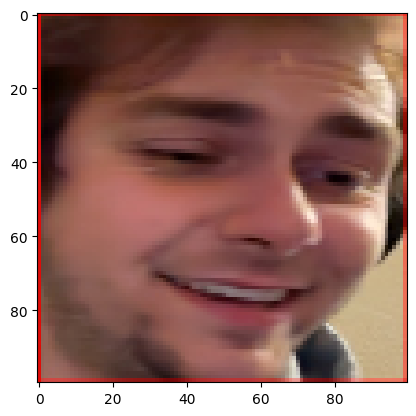

In [39]:
plt.imshow(training_images[0])

#### Augment data

In [40]:
augmentor = alb.Compose([alb.HorizontalFlip(p=0.5),
                         alb.RandomBrightnessContrast(p=0.1),
                         alb.RandomGamma(p=0.1),
                         alb.RGBShift(p=0.1),
                         alb.VerticalFlip(p=0.5)])

l = len(training_images)
t_orig = time.time()
total_photos = l
total_processed = 0
t = time.time()
print("Augmenting {} images in training data...".format(total_photos))
for i in range(l):
    for j in range(NUM_AUGMENTATIONS_PER_IMAGE):
        training_images.append(np.array(augmentor(image=training_images[i])['image']))
        training_labels.append(training_labels[i])
    total_processed += 1
    t = display_progressbar(t1=t, t_orig=t_orig, total_photos=total_photos, total_processed=total_processed)
display_progressbar(t1=10, t_orig=0, total_photos=total_photos, total_processed=total_photos)
print("\r\nDone!")

l = len(test_images)
t_orig = time.time()
total_photos = l
total_processed = 0
t = time.time()
print("Augmenting {} images in test data...".format(total_photos))
for i in range(l):
    for j in range(NUM_AUGMENTATIONS_PER_IMAGE):
        test_images.append(np.array(augmentor(image=test_images[i])['image']))
        test_labels.append(test_labels[i])
    total_processed += 1
    t = display_progressbar(t1=t, t_orig=t_orig, total_photos=total_photos, total_processed=total_processed)
display_progressbar(t1=10, t_orig=0, total_photos=total_photos, total_processed=total_photos)
print("\r\nDone!")

l = len(val_images)
t_orig = time.time()
total_photos = l
total_processed = 0
t = time.time()
print("Augmenting {} images in validation data...".format(total_photos))
for i in range(l):
    for j in range(NUM_AUGMENTATIONS_PER_IMAGE):
        val_images.append(np.array(augmentor(image=val_images[i])['image']))
        val_labels.append(val_labels[i])
    total_processed += 1
    t = display_progressbar(t1=t, t_orig=t_orig, total_photos=total_photos, total_processed=total_processed)
display_progressbar(t1=10, t_orig=0, total_photos=total_photos, total_processed=total_photos)
print("\r\nDone!")

Augmenting 11989 images in training data...
11989/11989 [==============================] - ETA: 0:00
Done!
Augmenting 1539 images in test data...
1539/1539 [==============================] - ETA: 0:00
Done!
Augmenting 1514 images in validation data...
1514/1514 [==============================] - ETA: 0:00
Done!


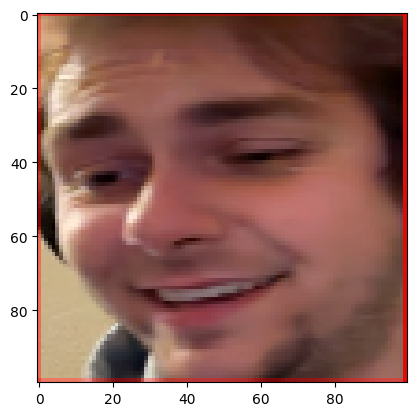

In [49]:
plt.imshow(np.array(augmentor(image=training_images[0])['image']))

#### Shuffling and converting to Numpy Arrays

In [14]:
print("Shuffling...")
(training_images, training_labels) = shuffle_arrays_in_sync(training_images, training_labels)
(test_images, test_labels) = shuffle_arrays_in_sync(test_images, test_labels)
(val_images, val_labels) = shuffle_arrays_in_sync(val_images, val_labels)
print("Converting to numpy arrays...")
training_images = np.array(training_images)
training_labels = np.array(training_labels)
test_images = np.array(test_images)
test_labels = np.array(test_labels)
val_images = np.array(val_images)
val_labels = np.array(val_labels)
print("Done!")

Shuffling...


KeyboardInterrupt: 

#### Check Shapes

In [ ]:
s = training_images[0].shape
print("Shape: " + str(s))
for i in range((training_images.shape)[0]):
    if training_images[i].shape != s:
        print("SHAPE MISMATCH")
        print("Shape s: " + str(s) + ", Shape at index i: " + str(training_images[i].shape))
for i in range((test_images.shape)[0]):
    if training_images[i].shape != s:
        print("SHAPE MISMATCH")
        print("Shape s: " + str(s) + ", Shape at index i: " + str(test_images[i].shape))
for i in range((val_images.shape)[0]):
    if training_images[i].shape != s:
        print("SHAPE MISMATCH")
        print("Shape s: " + str(s) + ", Shape at index i: " + str(val_images[i].shape))

#### Create model

In [ ]:
model = models.Sequential()
model.add(layers.Conv2D(64, (10,10), activation='relu', input_shape=(100, 100, 3)))
model.add(layers.MaxPooling2D(64, (2,2), padding='same'))
model.add(layers.Conv2D(128, (7,7), activation='relu'))
model.add(layers.MaxPooling2D(64, (2,2), padding='same'))
model.add(layers.Conv2D(128, (4,4), activation='relu'))
model.add(layers.MaxPooling2D((2,2), padding='same'))
model.add(layers.Conv2D(256, (4,4), activation='sigmoid'))
model.add(layers.Flatten())
model.add(layers.Dense(1))
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

model.summary()

#### Train Model

In [ ]:
history = model.fit(training_images, training_labels, epochs=NUM_EPOCHS,
                    validation_data=(test_images, test_labels))

#### Evaluate Model

In [ ]:
test_loss, test_acc = model.evaluate(test_images,  test_labels, verbose=2)
print('\nTest accuracy:', test_acc)

loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss with Modified Data")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

#### Save the Model

In [ ]:
model.save('model_final.h5')